In [77]:
import numpy as np
from scipy import special
from scipy import integrate
from scipy.integrate import quad
import astropy.constants as cte #cte
import astropy.units as unt  #unt
from tqdm.auto import tqdm
import sympy as sp
import math
import matplotlib.pyplot as plt

pc    = cte.pc.to_value()
kpc   = cte.kpc.to_value()
c     = cte.c.to_value()
MSun  = cte.M_sun.to_value()
G_num = cte.G.to_value()
time  = 3600 # es una hora en segundos
rs    = 21.5*kpc
d_s   = 770*kpc

In [78]:
def rE(m, d):
    D   = d*(1-d/d_s)
    arg = 4*G_num*(m*MSun)*D/c**2
    rE  = np.sqrt(abs(arg)) #R_E al cuadrado
    return rE

def v_r(tE, rE, y):
    te = tE*time #3600 es una hora en segundos
    return 2*rE*np.sqrt(1-y**2)/te

def r_MW(d,l,b):
    '''
    Distancia de PBH al centro de MW, en terminos de d. 
    
    d: distancia observador-lente.
    '''
    R_0  = 8.5*kpc
    r_mw = np.sqrt(R_0**2 + d**2 - 2*R_0*d*np.cos(math.radians(l))*np.cos(math.radians(b))) 
    return r_mw

def r_M31(d):
    '''
    Distancia para PBH del centro de M31. Ecuacion 10.
    
    d_s: distancia del observador a la fuente.
    '''
    r_m31 = d_s - d
    return r_m31

In [79]:
def density_DM(d,l,b):
    
    '''
    Densidad de DM en MW.
    '''
    term1 =  rho_c_MW
    term2 = (r_MW(d,l,b) / r_s_MW)
    term3 = (1 + r_MW(d,l,b) / r_s_MW)**2
    return (term1 /(term2 * term3)) #+  (term4 / (term5 * term6)) 

def M_nfw(rho_0,d):
    l       = 121.2 # degree
    b       = -21.6 # degree
    R_0     = 8.5*kpc
    rs      = 21.5*kpc
    C       = r_MW(d,l,b)/rs
    return 4*np.pi*rho_0*rs**3*(np.log(1+C)-C/(1+C))

def vc(d,M_nfw):
    l       = 121.2 # degree
    b       = -21.6 # degree
    return np.sqrt(abs(G_num*M_nfw/r_MW(d,l,b)))

@np.vectorize
def integrand_HSC(d,y,t,m):
    '''
    integrando tasa de eventos en MW.
    '''
    rho_0   = rho_c_MW
    exp_fac = np.exp(-v_r(t,rE(m,d),y)**2/vc(d,M_nfw(rho_0,d))**2)
    M       = m*MSun
    tE      = t*time
    E       = 7*time*t #3600 es una hora en segundos
    return 2*exp_fac*density_DM(d,l,b)*v_r(t,rE(m,d),y)**4/(np.sqrt(1-y**2)*M*vc(d,M_nfw(rho_0,d))**2)*(3600**2)                             

In [80]:
# M31 
def density_DM2(d,l,b):
    
    '''
    Densidad de DM en M31.
    '''
    term4 = rho_c_M31               
    term5 = (r_M31(d) / r_s_M31)
    term6 = (1 + r_M31(d) / r_s_M31)**2
    return  (term4 / (term5 * term6)) 

def M_nfw2(rho_0,d,rs):
    '''
    Función debajo de la ecuacion (13).
    '''
    l       = 121.2 # degree
    b       = -21.6 # degree
    C       = r_M31(d)/rs
    return  4*np.pi*rho_0*rs**3*(np.log(1+C)-C/(1+C))

def vc2(d,M_nfw2):
    '''
    velocidad de dispersion en M31. Ecuacion (13).
    '''
    return np.sqrt(abs(G_num*M_nfw2/r_M31(d)))

@np.vectorize
def integrand_HSC2(d,y,t,m):
    rho_0   = rho_c_M31
    exp_fac = np.exp(-v_r(t,rE(m,d),y)**2/vc2(d,M_nfw2(rho_0,d,r_s_M31))**2)
    M       = m*MSun
    tE      = t*time
    E       = 7*time*t #3600 es una hora en segundos
    return 2*exp_fac*density_DM2(d,l,b)*v_r(t,rE(m,d),y)**4/(np.sqrt(1-y**2)*M*vc2(d,M_nfw2(rho_0,d,r_s_M31))**2)*(3600**2)                             

In [81]:
d         = sp.Symbol('d')
d_s       = sp.Symbol('d_s')
rho_c_MW  = 4.88 * 10**6 * (MSun/kpc**3)
rho_c_M31 = 4.96 * 10**6 * (MSun/kpc**3)
r_s_MW    = 21.5 * kpc
r_s_M31   = 25 * kpc
d_s       = 770 * kpc
l         = 121.2 # degree
b         = -21.6 # degree

In [82]:
# TASA DE EVENTOS DE HSC

# @np.vectorize
def dG_dt_HSC(t,M):
    ti  = t[0]
    tf  = t[1]
    t   = np.logspace(ti,tf,25)
#     t   = np.linspace(10**ti,10**tf,50)
    I_k = np.zeros([len(t)])
    for i in tqdm(range(len(t))):
        I_j = integrate.dblquad(lambda y, d: integrand_HSC(d,y,t[i],M), 0, d_s, lambda d: 0, lambda d: 1,epsrel=1e-20)
        I_j2 = integrate.dblquad(lambda y, d: integrand_HSC2(d,y,t[i],M), 0, d_s, lambda d: 0, lambda d: 1,epsrel=1e-20)
        I_k[i] = I_j[0]+ I_j2[0]
    return I_k,t

In [14]:
m = [1e-7,1e-8,1e-9,1e-10,1e-11,1e-12]
# m = [1e-7,1e-8,1e-9,1e-10,1e-11,1e-12,1e-6,1e-5,1e-4]
dgdt,t = dG_dt_HSC([-2,1],1e-7)
dgdt1,t = dG_dt_HSC([-2,1],1e-8)
dgdt2,t = dG_dt_HSC([-2,1],1e-9)
dgdt3,t = dG_dt_HSC([-2,1],1e-10)
dgdt4,t = dG_dt_HSC([-2,1],1e-11)
dgdt5,t = dG_dt_HSC([-2,1],1e-12)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

c:\users\aniba\appdata\local\programs\python\python39\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

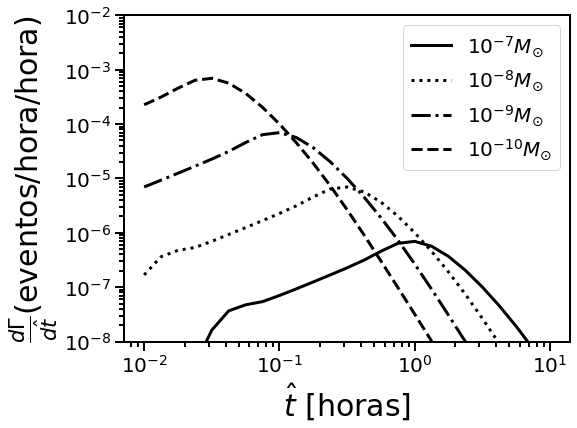

In [15]:
plt.figure(figsize=(8,6))
ax=plt.axes()

plt.ylim(1e-8,1e-2)
plt.loglog(t,dgdt,linestyle='-',lw=3,color='black',label='$10^{-7}M_{\odot}$')
plt.loglog(t,dgdt1,linestyle='dotted',lw=3,color='black',label='$10^{-8}M_{\odot}$')
plt.loglog(t,dgdt2,linestyle='-.',lw=3,color='black',label='$10^{-9}M_{\odot}$')
plt.loglog(t,dgdt3,linestyle='dashed',lw=3,color='black',label='$10^{-10}M_{\odot}$')
# plt.loglog(t,dgdt4,linestyle='--',lw=3,color='black',label='$1M_{\odot}$')
# plt.loglog(t,dgdt5,linestyle='-',lw=3,color='black',label='$1M_{\odot}$')

plt.ylabel(r'$\frac{d\Gamma}{d\hat{t}}$(eventos/hora/hora)',fontsize=30)
plt.xlabel(r'$\hat{t}$ [horas]',fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=9)
ax.tick_params(which='minor', length=5, color='black')
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=9)
ax.tick_params(which='minor', length=5, color='black')
plt.legend(loc='best',fontsize=20)

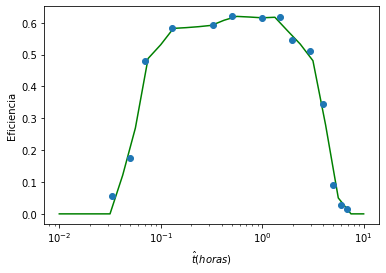

In [55]:
from scipy.interpolate import InterpolatedUnivariateSpline
import pandas as pd

eficiencia_hsc= pd.read_csv("eficiency_HSC.txt", decimal='.', sep=';')
eficiencia_hsc = eficiencia_hsc.values
t_efi = eficiencia_hsc[:,0]
Efi = eficiencia_hsc[:,1]

t_efi = list(t_efi)
Efi = list(Efi)

tck = InterpolatedUnivariateSpline(t_efi, Efi,k=1)

x= np.linspace(0,200,500)

def eficy(x):
    
    if x>6.85:
        efichi = 0
    elif x<0.032:
        efichi = 0
    else:
        efichi = tck(x)
    return efichi

def funcion(t):
    efic = []
    for T in t:
        efic.append(float(eficy(T)))
    return efic

eficiencia = []

t=[-2,1]
ti  = t[0]
tf  = t[1]
hat_t   = np.logspace(ti,tf,25)

for t in hat_t:
    eficiencia.append(eficy(t))

plt.ylabel('Eficiencia')    
plt.xlabel('$\hat{t}(horas)$')
plt.semilogx(hat_t, eficiencia,'green')
plt.semilogx(eficiencia_hsc[:,0],eficiencia_hsc[:,1],'o')

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

c:\users\aniba\appdata\local\programs\python\python39\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

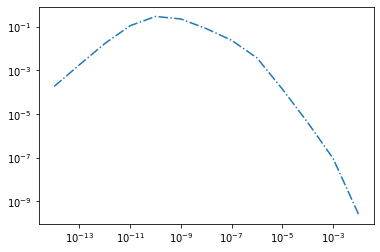

In [83]:
from scipy.integrate import simps
E=7e+4
M =  [1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12,1e-13,1e-14]
N = []

for i in tqdm(range(len(M))):
    G,tE = dG_dt_HSC([-2,1],M[i])
    int_G = simps(G*0.5*eficiencia,tE)
    N.append(int_G)

[2.28189911e-06 8.02115984e-04 3.55891607e-02 1.20525153e+00
 3.22356168e+01 2.07389416e+02 7.12028412e+02 1.96311531e+03
 2.56983392e+03 9.68424164e+02 1.48570582e+02 1.58205228e+01
 1.59257853e+00]


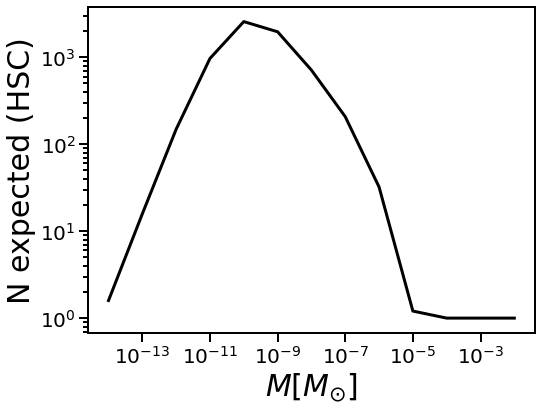

In [127]:
# plt.loglog(M,np.array(N)*7*8.7e+7,'-.')

#redefino un vector que reemplace los valores menores a uno en el numero esperado de eventos por 1
N2 = []
for i in range(len(N)):
    n = N[i]*7*8.7e+7
    if n<1:
        n=1
    N2.append(n) 
print(np.array(N)*7*8.7e+7)
    

plt.figure(figsize=(8,6))
ax=plt.axes()

plt.loglog(M,np.array(N2), linestyle='-', lw=3, color='black')

plt.xlabel(r'$M [M_{\odot}]$',fontsize=30)
plt.ylabel(r'N expected (HSC)',fontsize=30)
# plt.legend(loc='best',fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=9)
ax.tick_params(which='minor', length=5, color='black')

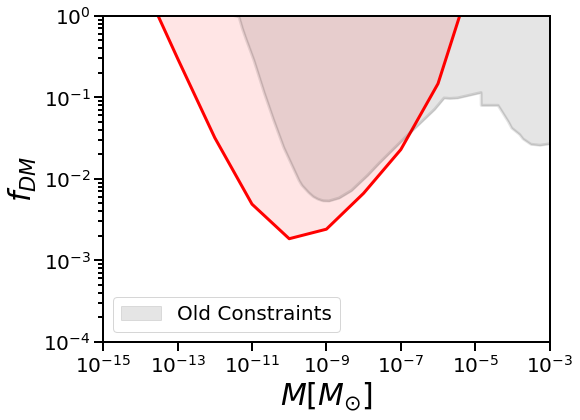

In [111]:
plt.figure(figsize=(8,6))
ax=plt.axes()

plt.ylim(1e-4,1)
plt.xlim(1e-15,1e-3)
plt.loglog(M,4.74/(7*8.7e+7*np.array(N)),lw=3,color='red',linestyle='-')
b = np.loadtxt('Microlensing-copy1.txt')

plt.loglog(b[:,0],b[:,1],color='black',alpha=0.1,linestyle='-',lw=3)
plt.fill_between(b[:,0],b[:,1],1,color='black', alpha=0.1,label='Old Constraints')

plt.fill_between(M,4.74/(7*8.7e+7*np.array(N)),1, color='red',alpha=0.1)


plt.xlabel(r'$M [M_{\odot}]$',fontsize=30)
plt.ylabel(r'$f_{DM}$',fontsize=30)
plt.legend(loc='best',fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=9)
ax.tick_params(which='minor', length=5, color='black')
